In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,)),])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
def loss_accu(model, rate, b_size):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    mnist_train = torch.utils.data.DataLoader(train_dataset, batch_size = b_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = rate)
    
    
    for epoch in range(6):
        running_loss = 0.0
        running_correct = 0
        for i, data in enumerate(mnist_train, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
        train_loss = (running_loss / len(mnist_train))
        train_losses.append(train_loss)
        train_accuracy = (running_correct / len(mnist_train.dataset))
        train_accuracies.append(train_accuracy)
    
        test_loss = 0.0
        test_correct = 0
        with torch.no_grad():
            for data in mnist_test:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()
        test_loss /= len(mnist_test)
        test_losses.append(test_loss)
        test_accuracy = test_correct / len(mnist_test.dataset)
        test_accuracies.append(test_accuracy)
        #print(train_loss, train_accuracy)
    return train_losses, train_accuracies, test_losses, test_accuracies

In [5]:
batch64 = CNN()
print(" Batch Size 64")
train_losses1, train_accuracies1, test_losses1, test_accuracies1 = loss_accu(batch64, rate=0.001, b_size=64)


 Batch Size 64


In [6]:
batch1024 = CNN()
print(" Batch Size 1024")
train_losses2, train_accuracies2, test_losses2, test_accuracies2 = loss_accu(batch1024, rate=0.001, b_size=1024)

 Batch Size 1024


In [7]:
params64 = torch.nn.utils.parameters_to_vector(batch64.parameters())
params1024 = torch.nn.utils.parameters_to_vector(batch1024.parameters())

In [8]:
import numpy as np
Alpha = np.arange(-1,2.15,0.15)
Train_Losses = []
Train_Accu = []
Test_Losses = []
Test_Accu = []

for i in range(len(Alpha)):
    print(Alpha[i])
    param_new = (1 - Alpha[i]) * params64 + Alpha[i] * params1024
    model = CNN()
    torch.nn.utils.vector_to_parameters(param_new, model.parameters())
    train_losses, train_accuracies, test_losses, test_accuracies = loss_accu(model, rate=0.001, b_size=64)
    print(min(train_losses),train_accuracies[-1],test_losses[0],test_accuracies[0])
    Train_Losses.append(min(train_losses))
    Train_Accu.append(train_accuracies[-1])
    
    Test_Losses.append(test_losses[0])
    Test_Accu.append(test_accuracies[0])


-1.0
0.10033393445937806 0.97105 0.502484339625718 0.9422
-0.85
0.09926280231790434 0.9706166666666667 0.5235562743678405 0.9199
-0.7
0.10260869992642736 0.9687333333333333 0.31844182136382576 0.948
-0.5499999999999999
0.10823393844491018 0.9679833333333333 0.2692414595549748 0.9447
-0.3999999999999999
0.11740720683414894 0.9653833333333334 0.23175933449321492 0.944
-0.2499999999999999
0.12998428474515994 0.96155 0.22618238580454686 0.9392
-0.09999999999999987
0.1466056514086563 0.9574 0.19678159983484608 0.9404
0.050000000000000266
0.16556205378094715 0.9515166666666667 0.22707860447039271 0.9352
0.20000000000000018
0.18529493320407645 0.9461 0.27908112089725057 0.9262
0.3500000000000001
0.20768823365428682 0.9390166666666667 0.3468316974723415 0.9124
0.5000000000000002
0.23550356988475393 0.9303 0.44156600781686745 0.8954
0.6500000000000004
0.2646721187653318 0.9214 0.5964981336502513 0.8599
0.8000000000000003
0.2724833393544912 0.9187166666666666 0.7573689605779709 0.8214
0.95000000

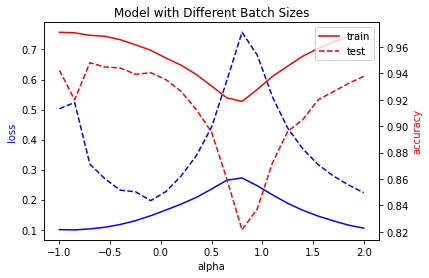

In [9]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(Alpha, Train_Losses, 'b', label='train')
ax1.plot(Alpha, Test_Losses, 'b--', label='test')
ax2.plot(Alpha, Train_Accu, 'r', label='train')
ax2.plot(Alpha, Test_Accu, 'r--', label='test')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend()
ax2.legend(loc='upper right')
ax1.set_title('Model with Different Batch Sizes')

In [10]:
##Different learning rate

rate001 = CNN()
print("learning rate 0.01")
train_losses3, train_accuracies3, test_losses3, test_accuracies3 = loss_accu(rate001, rate=0.01, b_size=64)

learning rate 0.01


In [16]:
rate0001 = CNN()
print("learning rate 0.001")
train_losses4, train_accuracies4, test_losses4, test_accuracies4 = loss_accu(rate0001, rate=0.001, b_size=64)

learning rate 0.001


In [17]:
params001 = torch.nn.utils.parameters_to_vector(rate001.parameters())
params0001 = torch.nn.utils.parameters_to_vector(rate0001.parameters())

In [21]:
Alpha1 = np.arange(-1,2.15,0.15)
Train_Losses1 = []
Train_Accu1 = []
Test_Losses1 = []
Test_Accu1 = []

for i in range(len(Alpha1)):
    print(Alpha1[i])
    param_new1 = (1 - Alpha1[i]) * params001 + Alpha1[i] * params0001
    model = CNN()
    torch.nn.utils.vector_to_parameters(param_new1, model.parameters())
    train_losses, train_accuracies, test_losses, test_accuracies = loss_accu(model, rate=0.001, b_size=64)
    print(min(train_losses),train_accuracies[-1],test_losses[0],test_accuracies[0])
    Train_Losses1.append(min(train_losses))
    Train_Accu1.append(train_accuracies[-1])
    
    Test_Losses1.append(test_losses[0])
    Test_Accu1.append(test_accuracies[0])


-1.0
0.21507032342526392 0.9844666666666667 0.23122717022402034 0.9849
-0.85
0.16619175901130998 0.985 0.1733089020658842 0.984
-0.7
0.12390530736513598 0.98535 0.12877563796659172 0.9853
-0.5499999999999999
0.092644303228086 0.9855833333333334 0.09778228876648173 0.9855
-0.3999999999999999
0.06802433074863011 0.986 0.06515227555852689 0.9858
-0.2499999999999999
0.051025104119547214 0.9868166666666667 0.04899160134818364 0.9866
-0.09999999999999987
0.04323378874367894 0.9871166666666666 0.04134836220805337 0.9866
0.050000000000000266
0.05040076025860952 0.98625 0.04874435577328038 0.9849
0.20000000000000018
0.08341858780452374 0.9814166666666667 0.08425109960423534 0.9823
0.3500000000000001
0.1401517082140771 0.9697833333333333 0.151441564747862 0.9708
0.5000000000000002
0.23043360805778362 0.9420666666666667 0.2584269629542235 0.9429
0.6500000000000004
0.30502559174733884 0.9162833333333333 0.324039370770667 0.9171
0.8000000000000003
0.2800133812910458 0.9212333333333333 0.28648948403

Text(0.5, 1.0, 'Learning Rate 0.01 vs 0.001')

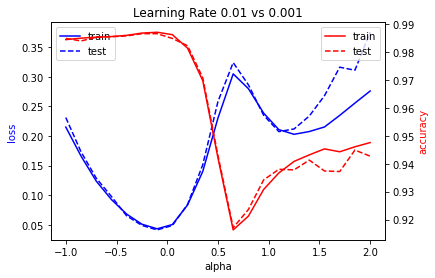

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(Alpha1, Train_Losses1, 'b', label='train')
ax1.plot(Alpha1, Test_Losses1, 'b--', label='test')
ax2.plot(Alpha1, Train_Accu1, 'r', label='train')
ax2.plot(Alpha1, Test_Accu1, 'r--', label='test')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend()
ax2.legend(loc='upper right')
ax1.set_title('Learning Rate 0.01 vs 0.001')